In [ ]:
# !pip install tensorflow

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from time import perf_counter
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

def printmd(string):
    # Print with Markdowns    
    display(Markdown(string))

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# in hosted runtime
# %cd '/content/drive/MyDrive/Colab Notebooks/ASL'

In [ ]:
# in local runtime
%cd '/Users/maruf_maruf1/Google Drive/Colab Notebooks/ASL'

/Users/maruf_maruf1/Google Drive/Colab Notebooks/ASL


In [ ]:
!ls -la

In [ ]:
# !unzip archive.zip -d dataset

In [ ]:
# Create a list with the filepaths for training and testing
dir_ = Path('dataset/asl_alphabet_train')
file_paths = list(dir_.glob(r'**/*.jpg'))

In [ ]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("/")[-2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(file_paths)

print(f'Number of pictures in the dataset: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

mp={}
for i in range(0,30):
  mp[i]=df.Label[i]
print(mp)

# The DataFrame with the filepaths in one column and the labels in the other one
df.head(5)

Number of pictures in the dataset: 87000

Number of different labels: 29

Labels: ['L' 'Z' 'J' 'H' 'space' 'I' 'del' 'G' 'S' 'A' 'B' 'W' 'P' 'nothing' 'M'
 'C' 'E' 'V' 'K' 'O' 'R' 'T' 'N' 'Y' 'U' 'D' 'X' 'Q' 'F']
{0: 'L', 1: 'Z', 2: 'J', 3: 'H', 4: 'space', 5: 'I', 6: 'del', 7: 'G', 8: 'G', 9: 'H', 10: 'S', 11: 'A', 12: 'B', 13: 'B', 14: 'W', 15: 'P', 16: 'B', 17: 'nothing', 18: 'J', 19: 'H', 20: 'nothing', 21: 'M', 22: 'W', 23: 'H', 24: 'C', 25: 'Z', 26: 'nothing', 27: 'E', 28: 'M', 29: 'V'}


,Filepath,Label
0,dataset/asl_alphabet_train/asl_alphabet_train/...,L
1,dataset/asl_alphabet_train/asl_alphabet_train/...,Z
2,dataset/asl_alphabet_train/asl_alphabet_train/...,J
3,dataset/asl_alphabet_train/asl_alphabet_train/...,H
4,dataset/asl_alphabet_train/asl_alphabet_train/...,space


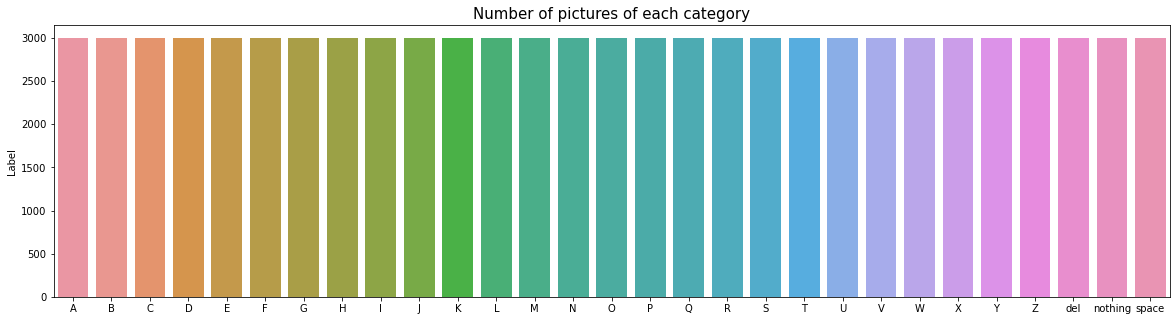

In [ ]:
# Display the number of pictures of each category
vc = df['Label'].value_counts()
plt.figure(figsize=(20,5))
# sns.barplot(x = sorted(vc.index), y = vc, palette = "rocket")
sns.barplot(x = sorted(vc.index), y = vc)
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

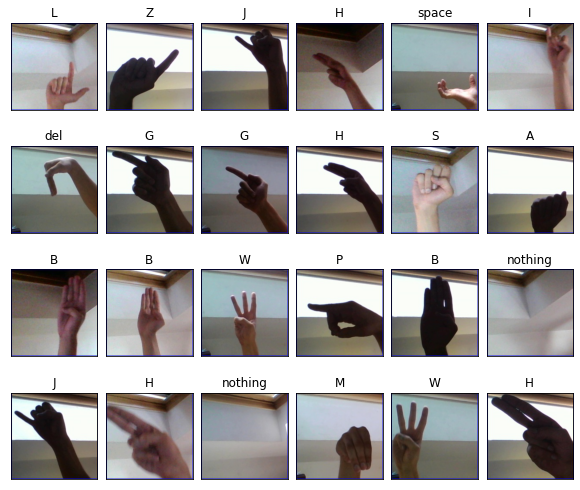

In [ ]:
# Display some pictures of the dataset
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [ ]:
# # Use 5% of the dataset for testing various models
# # Split into training and test datasets
# train_df, test_df = train_test_split(df.sample(frac = 0.05), test_size=0.2, random_state=0)

In [ ]:
def create_gen():
    # Load the Images with a generator and Data Augmentation
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
        validation_split=0.1
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='validation',
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.1, random_state=0)

train_generator,test_generator,train_images,val_images,test_images=create_gen()



Found 70470 validated image filenames belonging to 29 classes.
Found 7830 validated image filenames belonging to 29 classes.
Found 8700 validated image filenames belonging to 29 classes.


In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet',
                                               pooling='avg')
pretrained_model.trainable = False
    
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(29, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

print("Number of layers in the base model: ", len(pretrained_model.layers))


# model.summary()

Number of layers in the base model:  155


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# load existing weight
# model.load_weights('model-weight-v2.h5')

In [ ]:
Train the model
history = model.fit(train_images,
                    validation_data=val_images,
                    epochs=5,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            verbose=2,
                            patience=2,
                            restore_best_weights=True)
                        ]
                    )

In [ ]:
# history.history

In [ ]:
# model.save('model-weight-v2.h5')

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
ax = axes.flat

pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot(ax=ax[0])
ax[0].set_title("Accuracy", fontsize = 15)
ax[0].set_ylim(0,1.1)

pd.DataFrame(history.history)[['loss','val_loss']].plot(ax=ax[1])
ax[1].set_title("Loss", fontsize = 15)
plt.show()

In [ ]:
def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.savefig('./loss_curve.png')

plot_learning_curve(history)
plt.show()

In [ ]:
predic = model.predict(test_images)
pred = np.argmax(predic,axis=1)

[23 25  8 ... 27 18  5]


In [ ]:
j=0
for i in pred:
    print(i)
    if j>10:
      break
    j+=1

In [ ]:
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [ ]:
print(labels)
print(pred)
print(train_images.class_indices)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'}
['X', 'Z', 'I', 'X', 'O', 'R', 'Z', 'V', 'C', 'del', 'J', 'V', 'I', 'D', 'T', 'G', 'Q', 'Z', 'F', 'nothing', 'F', 'G', 'X', 'G', 'O', 'O', 'E', 'Y', 'G', 'M', 'Z', 'K', 'S', 'O', 'V', 'K', 'M', 'space', 'J', 'E', 'I', 'X', 'H', 'C', 'T', 'L', 'S', 'del', 'S', 'C', 'P', 'I', 'X', 'X', 'V', 'U', 'W', 'E', 'W', 'W', 'V', 'E', 'X', 'Z', 'U', 'C', 'R', 'E', 'C', 'S', 'J', 'O', 'M', 'X', 'B', 'L', 'Z', 'U', 'G', 'O', 'N', 'Y', 'R', 'B', 'I', 'G', 'H', 'U', 'I', 'W', 'M', 'F', 'E', 'N', 'N', 'Z', 'P', 'del', 'I', 'C', 'del', 'R', 'del', 'G', 'H', 'H', 'Y', 'H', 'Z', 'W', 'D', 'U', 'E', 'G', 'S', 'G', 'M', 'N', 'X', 'K', 'Q', 'nothing', 'Y', 'O', 'N', 'D', 'O', 'J', 'P', 'P', 'H', 'A', 'J', 'Y', 'L', 'L', 'D', 'X', 'V', 'R', 'Z', 'T',

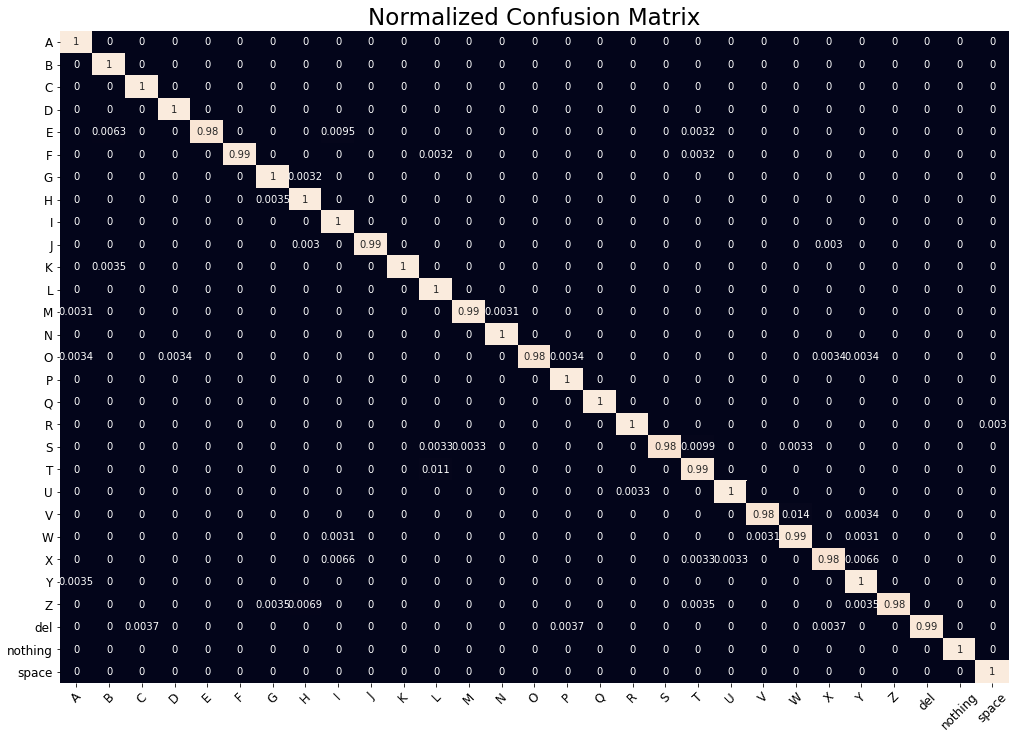

In [ ]:
y_test = list(test_df.Label)
acc = accuracy_score(y_test,pred)

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (17,12))
sns.heatmap(cf_matrix, annot=True, xticklabels = sorted(set(y_test)), yticklabels = sorted(set(y_test)),cbar=False)
plt.title('Normalized Confusion Matrix', fontsize = 23)
plt.xticks(fontsize=12,rotation=45)
plt.yticks(fontsize=12)
plt.show()

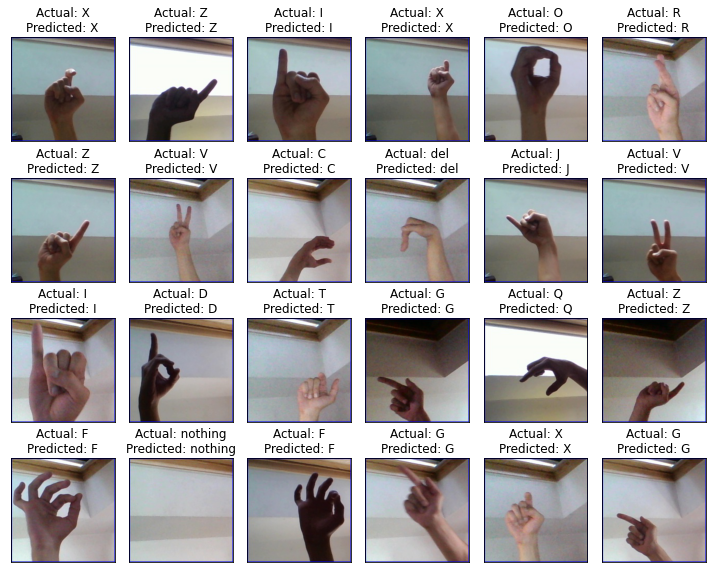

In [ ]:
fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(10, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"Actual: {test_df.Label.iloc[i].split('_')[0]}\nPredicted: {pred[i].split('_')[0]}", fontsize = 12)
plt.tight_layout()
plt.show()

In [ ]:
eval = model.evaluate(test_images)

In [ ]:
eval

In [ ]:
tf.saved_model.save(model, 'saved-model')

In [ ]:
from tensorflow.keras.models import load_model

new_model = load_model('model-weight-v2.h5')

In [ ]:
pred2 =new_model.evaluate(test_images)
pred2 = np.argmax(predic,axis=1)
print(pred2)

In [ ]:
for X, y in test_images:
    print(X.shape, y.shape)
    print(X[0].shape)
    plt.imshow(X[0])
    break

In [ ]:
import numpy as np
import cv2 as cv
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

# model = load_model('model-weight-v2.h5')
label_lines = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z', 26: 'del', 27: 'nothing', 28: 'space'}

from tensorflow.keras.preprocessing import image
import numpy as np

# dimensions of our images    -----   are these then grayscale (black and white)?
img_width, img_height = 224, 224

# load the model we saved
# model = load_model('model.h5')

width = 224
height = 224

#Load image by OpenCV
img = image.load_img('O1.jpg',(width,height))

#Resize to respect the input_shape
# inp = cv.resize(img, (width , height ))
plt.imshow(img)


#Convert img to RGB
rgb = cv.cvtColor(inp, cv.COLOR_BGR2RGB)

rgb = tf.keras.applications.mobilenet.preprocess_input(rgb)


#Is optional but i recommend (float convertion and convert img to tensor image)
# rgb_tensor = tf.convert_to_tensor(rgb)


#Add dims to rgb_tensor
rgb_tensor = tf.expand_dims(rgb , 0)
# test_image = np.expand_dims(test_image, axis=0)
print(rgb_tensor.shape)


# test_image = test_image.reshape(img_width, img_height, 3)    # Ambiguity!
# Should this instead be: test_image.reshape(img_width, img_height, 3) ??

result = new_model.predict(rgb_tensor)
predictions = np.argmax(result,axis=1)[0]
print(result)
print(predictions)

In [ ]:
new_model.summary()